In [ ]:
# Install required packages (run only once, then comment out)
# !pip install pandas matplotlib seaborn numpy scikit-learn joblib xgboost parameterized


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod
import os
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import tempfile
import shutil
import unittest
from parameterized import parameterized

METRICS BASE CLASS

In [6]:
class Metric(ABC):
    """Abstract base class for evaluation metrics. => define base common methods"""
    @abstractmethod
    def calculate(self, y_true, y_pred, **kwargs):
        """Calculate the metric value.
        
        Args:
            y_true: Array-like of true values.
            y_pred: Array-like of predicted values.
            **kwargs: Optional metric-specific parameters.
        
        Returns:
            Float representing the metric value.
        
        Raises:
            ValueError: If inputs are invalid (e.g., mismatched lengths, non-numeric).
        """
        pass
    
    @abstractmethod
    def name(self):
        """Return the metric's name."""
        pass
    
    @abstractmethod
    def description(self):
        """Return a description of the metric."""
        pass

CONCRETE METRIC CLASSES

In [7]:
class R2Metric(Metric):
    """R² (Coefficient of Determination) metric."""
    def calculate(self, y_true, y_pred, **kwargs):
        y_true, y_pred = self._validate_inputs(y_true, y_pred)
        return r2_score(y_true, y_pred)
    
    def name(self):
        return "R2"
    
    def description(self):
        return "Coefficient of Determination, measuring variance explained by the model."
    
    def _validate_inputs(self, y_true, y_pred):
        """Validate inputs for metric calculation."""
        y_true = np.array(y_true, dtype=float)
        y_pred = np.array(y_pred, dtype=float)
        if len(y_true) != len(y_pred):
            raise ValueError("y_true and y_pred must have the same length")
        if len(y_true) == 0:
            raise ValueError("Input arrays cannot be empty")
        if not np.all(np.isfinite(y_true)) or not np.all(np.isfinite(y_pred)):
            raise ValueError("Inputs must be numeric and finite")
        return y_true, y_pred

In [8]:
class MAEMetric(Metric):
    """Mean Absolute Error (MAE) metric."""
    def calculate(self, y_true, y_pred, **kwargs):
        y_true, y_pred = self._validate_inputs(y_true, y_pred)
        return mean_absolute_error(y_true, y_pred)
    
    def name(self):
        return "MAE"
    
    def description(self):
        return "Mean Absolute Error, measuring average absolute difference between predictions and actuals."
    
    def _validate_inputs(self, y_true, y_pred):
        return R2Metric._validate_inputs(self, y_true, y_pred)

In [9]:
class RMSEMetric(Metric):
    """Root Mean Squared Error (RMSE) metric."""
    def calculate(self, y_true, y_pred, **kwargs):
        y_true, y_pred = self._validate_inputs(y_true, y_pred)
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    def name(self):
        return "RMSE"
    
    def description(self):
        return "Root Mean Squared Error, measuring square root of average squared differences."
    
    def _validate_inputs(self, y_true, y_pred):
        return R2Metric._validate_inputs(self, y_true, y_pred)

EXAMPLE - ADD NEW TEST METRIC

In [ ]:
class MAPEMetric(Metric):
    """Symmetric Mean Absolute Percentage Error (sMAPE) metric."""
    def calculate(self, y_true, y_pred, **kwargs):
        y_true, y_pred = self._validate_inputs(y_true, y_pred)
        # Compute absolute differences and denominators
        absolute_diff = np.abs(y_true - y_pred)
        denominator = np.abs(y_true) + np.abs(y_pred)
        # Handle zero denominators with a small epsilon
        epsilon = 1e-10
        mask = denominator == 0
        denominator[mask] = epsilon
        # Compute percentage errors and average them
        percentage_errors = (absolute_diff / denominator) * 100
        return np.mean(percentage_errors)
    
    def name(self):
        return "sMAPE"
    
    def description(self):
        return "Symmetric Mean Absolute Percentage Error, measuring average percentage difference with symmetry, robust to zero values."
    
    def _validate_inputs(self, y_true, y_pred):
        return R2Metric._validate_inputs(self, y_true, y_pred)

EVALUATOR - MAIN IMPLEMENTATION/METRIC-CALLING CLASS

In [11]:
class Evaluator:
    """Class to evaluate predictions using multiple metrics."""
    def __init__(self, metrics):
        """Initialize with a list of Metric objects.
        
        Args:
            metrics: List of Metric objects to evaluate.
        """
        self.metrics = metrics
    
    def evaluate_from_csv(self, csv_path, true_col="Actual", pred_col="Predicted"):
        """Evaluate predictions from a CSV file.
        
        Args:
            csv_path: Path to CSV file with true and predicted values.
            true_col: Name of column with true values (default: 'Actual').
            pred_col: Name of column with predicted values (default: 'Predicted').
        
        Returns:
            Dict with metric names as keys and values as floats.
        
        Raises:
            FileNotFoundError: If CSV file does not exist.
            ValueError: If columns are missing or data is invalid.
        """
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"CSV file not found: {csv_path}")
        
        df = pd.read_csv(csv_path)
        if true_col not in df.columns or pred_col not in df.columns:
            raise ValueError(f"Columns {true_col} and/or {pred_col} not found in CSV")
        
        y_true = df[true_col]
        y_pred = df[pred_col]
        
        results = {}
        for metric in self.metrics:
            try:
                results[metric.name()] = metric.calculate(y_true, y_pred)
            except ValueError as e:
                print(f"Error calculating {metric.name()}: {e}")
        return results

    def evaluate_models(self, models, x_data, y_true, model_names):
        """Evaluate multiple models on provided data.
        
        Args:
            models: List of fitted model objects.
            x_data: Input features for prediction.
            y_true: True target values.
            model_names: List of model names corresponding to models.
        
        Returns:
            Dict with model names as keys and metric results as values.
        """
        results = {}
        for model, name in zip(models, model_names):
            try:
                y_pred = model.predict(x_data)
                model_results = {}
                for metric in self.metrics:
                    model_results[metric.name()] = metric.calculate(y_true, y_pred)
                results[name] = model_results
            except Exception as e:
                print(f"Error evaluating model {name}: {e}")
        return results

    def save_results_to_csv(self, results, save_path):
        """Save evaluation results to a CSV file.
        
        Args:
            results: Dict with model names as keys and metric results as values.
            save_path: Path to save the CSV file.
        """
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        data = {
            'Model': [],
            'Metric': [],
            'Value': []
        }
        for model_name, metrics in results.items():
            for metric_name, value in metrics.items():
                data['Model'].append(model_name)
                data['Metric'].append(metric_name)
                data['Value'].append(value)
        df = pd.DataFrame(data)
        df.to_csv(save_path, index=False)
        print(f"Evaluation results saved to {save_path}")

UTILITY FUNCTIONS

In [12]:
def plot_actual_vs_predicted(y_true, y_pred, model_name, save_path):
    """Plot actual vs predicted values for a specific model."""
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.xlabel("Actual Yield (kg/ha)")
    plt.ylabel("Predicted Yield (kg/ha)")
    plt.title(f"Actual vs Predicted Rice Yield ({model_name})")
    plt.grid(True)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.show()

def plot_residuals(y_true, y_pred, model_name, save_path):
    """Plot residuals distribution for a specific model."""
    residuals = np.array(y_true) - np.array(y_pred)
    plt.figure(figsize=(6, 5))
    sns.histplot(residuals, kde=True)
    plt.title(f"Residuals Distribution ({model_name})")
    plt.xlabel("Prediction Error")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.show()

UNIT TESTING TESTCASES

In [13]:
class TestMetrics(unittest.TestCase):
    """Enhanced unit tests for metrics and evaluator."""
    
    def setUp(self):
        # Valid test data
        self.y_true = [1, 2, 3, 4, 5]
        self.y_pred = [1.1, 2.2, 2.8, 4.1, 4.9]
        
        # Create a temp directory and CSV
        self.test_dir = tempfile.mkdtemp()
        self.temp_csv = os.path.join(self.test_dir, "temp_test.csv")
        df = pd.DataFrame({"Actual": self.y_true, "Predicted": self.y_pred})
        df.to_csv(self.temp_csv, index=False)

        # For evaluator
        self.metrics = [R2Metric(), MAEMetric(), RMSEMetric(), MAPEMetric()]
        self.evaluator = Evaluator(self.metrics)

        # Mock models for testing
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
        try:
            from xgboost import XGBRegressor
            self.xgb_available = True
        except ImportError:
            self.xgb_available = False
        
        self.models = [
            RandomForestRegressor(n_estimators=10, random_state=42),
            GradientBoostingRegressor(n_estimators=10, random_state=42)
        ]
        self.model_names = ["RandomForest", "GradientBoosting"]
        if self.xgb_available:
            self.models.append(XGBRegressor(n_estimators=10, random_state=42, verbosity=0))
            self.model_names.append("XGBoost")
        
        # Mock training data
        self.x_train = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
        self.y_train = np.array(self.y_true)
        for model in self.models:
            model.fit(self.x_train, self.y_train)
    
    def tearDown(self):
        shutil.rmtree(self.test_dir)

    @parameterized.expand([
        ("R2", R2Metric(), r2_score),
        ("MAE", MAEMetric(), mean_absolute_error),
        ("RMSE", RMSEMetric(), lambda y, yp: np.sqrt(mean_squared_error(np.array(y), np.array(yp)))),
        ("sMAPE", MAPEMetric(), lambda y, yp: np.mean(np.abs(np.array(y) - np.array(yp)) / (np.abs(np.array(y)) + np.abs(np.array(yp)) + 1e-10) * 100))
    ])
    
    def test_metric_calculation(self, name, metric, reference_fn):
        result = metric.calculate(self.y_true, self.y_pred)
        expected = reference_fn(self.y_true, self.y_pred)
        self.assertAlmostEqual(result, expected, places=6)

    def test_metric_metadata(self):
        for metric in self.metrics:
            self.assertIsInstance(metric.name(), str)
            self.assertTrue(len(metric.name()) > 0)
            self.assertIsInstance(metric.description(), str)

    def test_evaluator_from_csv(self):
        results = self.evaluator.evaluate_from_csv(self.temp_csv)
        self.assertIn("R2", results)
        self.assertIn("MAE", results)
        self.assertIn("RMSE", results)
        self.assertAlmostEqual(results["R2"], r2_score(self.y_true, self.y_pred), places=6)

    def test_evaluate_models(self):
        results = self.evaluator.evaluate_models(self.models, self.x_train, self.y_train, self.model_names)
        for model_name in self.model_names:
            self.assertIn(model_name, results)
            self.assertIn("R2", results[model_name])
            self.assertIn("MAE", results[model_name])
            self.assertIn("RMSE", results[model_name])

    def test_save_results_to_csv(self):
        results = self.evaluator.evaluate_models(self.models, self.x_train, self.y_train, self.model_names)
        save_path = os.path.join(self.test_dir, "results.csv")
        self.evaluator.save_results_to_csv(results, save_path)
        self.assertTrue(os.path.exists(save_path))
        df = pd.read_csv(save_path)
        self.assertEqual(len(df), len(self.metrics) * len(self.models))

    def test_invalid_csv_file_not_found(self):
        with self.assertRaises(FileNotFoundError):
            self.evaluator.evaluate_from_csv("/nonexistent/path/file.csv")
    
    def test_invalid_csv_missing_columns(self):
        df = pd.DataFrame({"Wrong": self.y_true})
        bad_csv = os.path.join(self.test_dir, "bad.csv")
        df.to_csv(bad_csv, index=False)
        with self.assertRaises(ValueError):
            self.evaluator.evaluate_from_csv(bad_csv)
    
    def test_invalid_input_shapes(self):
        metric = R2Metric()
        with self.assertRaises(ValueError):
            metric.calculate([1, 2], [1, 2, 3])
    
    def test_empty_inputs(self):
        metric = R2Metric()
        with self.assertRaises(ValueError):
            metric.calculate([], [])

    def test_non_numeric_inputs(self):
        metric = R2Metric()
        with self.assertRaises(ValueError):
            metric.calculate([1, "a"], [1, 2])

    def test_nan_inputs(self):
        metric = R2Metric()
        with self.assertRaises(ValueError):
            metric.calculate([1, np.nan], [1, 2])

    def test_inf_inputs(self):
        metric = R2Metric()
        with self.assertRaises(ValueError):
            metric.calculate([1, 2], [1, np.inf])

MAIN EXECUTION

LOADING DATA + SPLITTING 

In [24]:
try:
    # df = pd.read_csv('/content/rice_data_outlier_removed.csv')
    df = pd.read_csv('D:\\Shreya\\engg\\GSSoC\'25\\AI-agriculture-yield-production-GSSoC\\Datasets\\rice_data_outlier_removed.csv')
    x = df[['Year', 'RICE AREA (1000 ha)', 'RICE PRODUCTION (1000 tons)', 'State Code']]
    y = df['RICE YIELD (Kg per ha)']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    print("Data loaded and split successfully.")
except FileNotFoundError:
    print("Error: Dataset file '/content/rice_data_outlier_removed.csv' not found.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded and split successfully.


SCALING TEST DATA

In [26]:
try:
    # scaler = joblib.load('Models/scaler.pkl')
    scaler = joblib.load('D:\\Shreya\\engg\\GSSoC\'25\\AI-agriculture-yield-production-GSSoC\\Models\\scaler.pkl')
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    print("Scaler loaded and test data scaled successfully.")
except FileNotFoundError:
    print("Error: Scaler file 'Models/scaler.pkl' not found.")
except Exception as e:
    print(f"Error scaling data: {e}")

Scaler loaded and test data scaled successfully.


d:\Shreya\engg\GSSoC'25\AI-agriculture-yield-production-GSSoC\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [27]:
# These will store models and their names which will then be passed to Evaluator for evaluation
models = []
model_names = []

LOADING MODELS

In [28]:
try:
    # rf_model = joblib.load('Models/rf_model.pkl')
    rf_model = joblib.load('D:\\Shreya\\engg\\GSSoC\'25\\AI-agriculture-yield-production-GSSoC\\Models\\rf_model.pkl')
    models.append(rf_model)
    model_names.append("RandomForest")
    print("RandomForest model loaded successfully.")
except FileNotFoundError:
    print("Error: RandomForest model file 'Models/rf_model.pkl' not found.")

RandomForest model loaded successfully.


d:\Shreya\engg\GSSoC'25\AI-agriculture-yield-production-GSSoC\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Shreya\engg\GSSoC'25\AI-agriculture-yield-production-GSSoC\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
try:
    # xgb_model = joblib.load('Models/xgb_model.pkl')
    xgb_model = joblib.load('D:\\Shreya\\engg\\GSSoC\'25\\AI-agriculture-yield-production-GSSoC\\Models\\xgb_model.pkl')
    models.append(xgb_model)
    model_names.append("XGBoost")
    print("XGBoost model loaded successfully.")
except FileNotFoundError as e:
    print(f"XGBoost model not loaded: {e}")

XGBoost model loaded successfully.


In [30]:
# This is a test model added to test the modular functionality
from sklearn.linear_model import LinearRegression
try:
    lr_model = LinearRegression()
    lr_model.fit(x_train_scaled, y_train)
    models.append(lr_model)
    model_names.append("LinearRegression")
    print("LinearRegression model trained and added successfully.")
except (FileNotFoundError, ImportError) as e:
    print(f"LinearRegression model not trained or imported: {e}")

LinearRegression model trained and added successfully.


In [31]:
if not models:
    print("Warning: No models loaded successfully. Please check model files and dependencies.")

UNIT TESTING

In [32]:
print("Running unit tests...")
unittest.main(argv=[''], exit=False)

.

Running unit tests...


..............
----------------------------------------------------------------------
Ran 15 tests in 1.004s

OK


Evaluation results saved to C:\Users\shrey\AppData\Local\Temp\tmpwuh5fdxd\results.csv


EVALUATION OF MODELS THROUGH METRICS

In [33]:
try:
    if models:
        evaluator = Evaluator([R2Metric(), MAEMetric(), RMSEMetric(), MAPEMetric()])
        results = evaluator.evaluate_models(models, x_test_scaled, y_test, model_names)
        
        # Print results
        print("\nEvaluation Results:")
        for model_name, metrics in results.items():
            print(f"\n{model_name}:")
            for metric_name, value in metrics.items():
                print(f"  {metric_name}: {value:.4f}")
    else:
        print("No models available for evaluation.")
except Exception as e:
    print(f"Error evaluating models: {e}")


Evaluation Results:

RandomForest:
  R2: 0.8652
  MAE: 231.7965
  RMSE: 406.5588
  sMAPE: 6.4042

XGBoost:
  R2: 0.9142
  MAE: 214.4286
  RMSE: 324.4074
  sMAPE: 16.2209

LinearRegression:
  R2: 0.3697
  MAE: 659.1763
  RMSE: 879.2085
  sMAPE: 22.2613


SAVE EVALUATION RESULTS

In [34]:
try:
    if models and 'results' in locals():
        # evaluator.save_results_to_csv(results, 'Models/evaluation_results.csv')
        evaluator.save_results_to_csv(results, 'D:\\Shreya\\engg\\GSSoC\'25\\AI-agriculture-yield-production-GSSoC\\Models\\evaluation_results.csv')
    else:
        print("No evaluation results to save. Ensure models are loaded and evaluated.")
except Exception as e:
    print(f"Error saving evaluation results: {e}")

Evaluation results saved to D:\Shreya\engg\GSSoC'25\AI-agriculture-yield-production-GSSoC\Models\evaluation_results.csv


PLOT GRAPHS

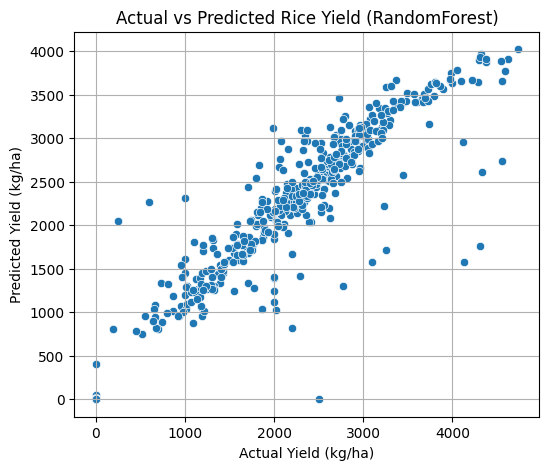

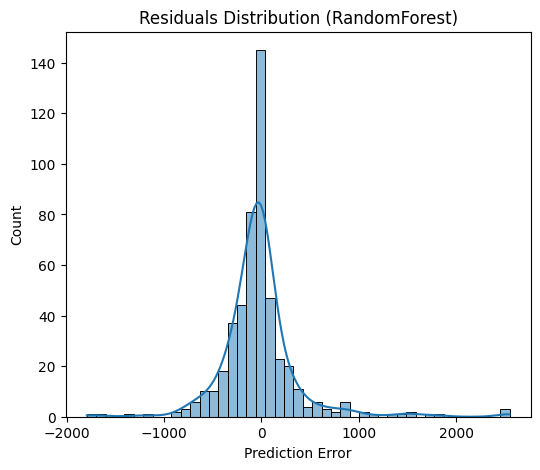

Plots generated for RandomForest.


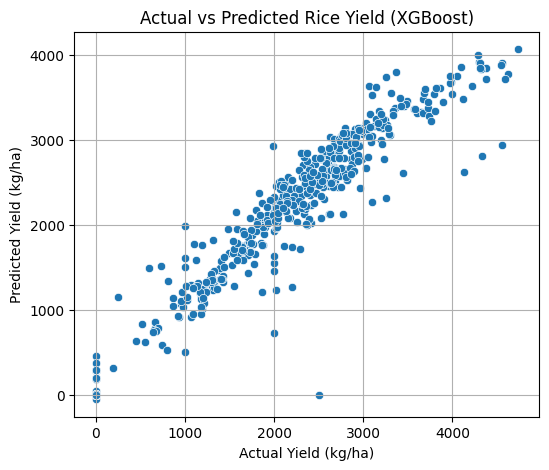

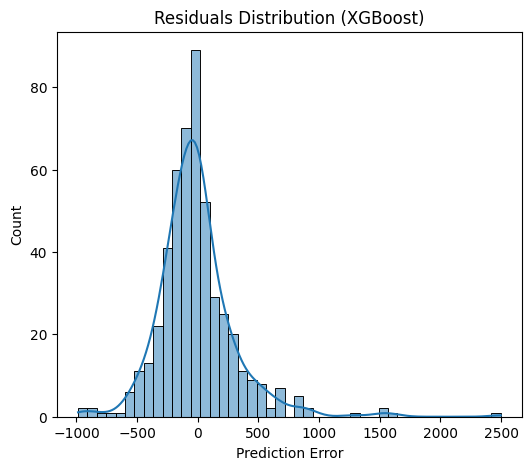

Plots generated for XGBoost.


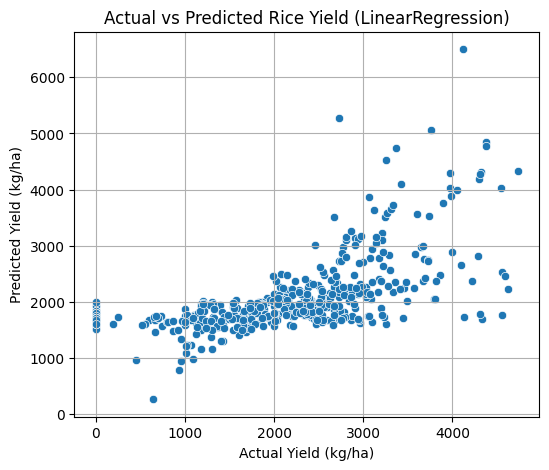

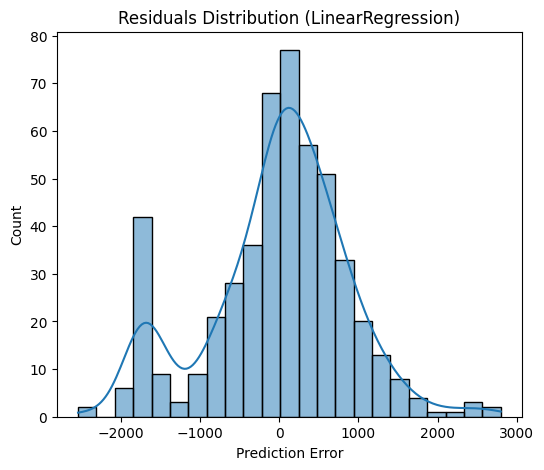

Plots generated for LinearRegression.


In [35]:
try:
    if models:
        plot_dir = "Plots"
        os.makedirs(plot_dir, exist_ok=True)

        for model, model_name in zip(models, model_names):
            y_pred = model.predict(x_test_scaled)

            plot_actual_vs_predicted(y_true=y_test, y_pred=y_pred, model_name=model_name, save_path=os.path.join(plot_dir, f"actual_vs_predicted_{model_name}.png"))

            plot_residuals(y_true=y_test, y_pred=y_pred, model_name=model_name, save_path=os.path.join(plot_dir, f"residuals_{model_name}.png"))
            print(f"Plots generated for {model_name}.")
    else:
        print("No models available for plotting.")
except Exception as e:
    print(f"Error generating plots: {e}")